# Trabajo Practico 2 - Sistemas Complejos

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math
import pandas as pd
from io import StringIO
import random
import scipy
import operator

In [2]:
golden_mean = (math.sqrt(5)-1.0)/2.0       # Aesthetic ratio
fig_width = 7+3/8                          # width  in inches
fig_height = fig_width*golden_mean         # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'ps',
          'axes.titlesize': 18,
          'axes.labelsize': 19,
          'axes.linewidth': 0.7, 
          'axes.grid': False,
          'axes.labelweight': 'normal',  
          'font.family': 'serif',
          'font.size': 18.0,
          'font.weight': 'normal',
          'text.color': 'black',
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'legend.fontsize': 16,
          'figure.dpi': 700,
          'figure.figsize': fig_size,
          'savefig.dpi': 700,
         }

pylab.rcParams.update(params)

Importacion de redes 

In [3]:
G_APMS = nx.read_edgelist('yeast_AP-MS.txt')
G_Y2H = nx.read_edgelist('yeast_Y2H.txt')
G_LIT = nx.read_edgelist('yeast_LIT.txt')

G_LIT_Reguly = nx.Graph()
data_lit_reguly = np.genfromtxt("yeast_LIT_Reguly.txt",dtype='unicode',delimiter = '\t')
yeast_LIT_Reguly_raw = [data_lit_reguly[1:,0],data_lit_reguly[1:,1]]

i=1
while i<len(data_lit_reguly[1:,0]):
    G_LIT_Reguly.add_edge(data_lit_reguly[i,0],data_lit_reguly[i,1])
    i+=1

Cargamos el archivo que contiene la esencialidad de los nodos

In [4]:
G_ESSENTIAL = nx.Graph()
data_G_ESSENTIAL = np.genfromtxt("Essential_ORFs_paperHe.txt",dtype='unicode',delimiter = '\t')
yeast_G_ESSENTIAL_raw = [data_G_ESSENTIAL[2:,1]]

i = 0
l = len(yeast_G_ESSENTIAL_raw[0][:])

while i < l:
    proteina = yeast_G_ESSENTIAL_raw[0][i]
    yeast_G_ESSENTIAL_raw[0][i] = proteina.rstrip(" ")
    i+=1

Caracteristicas basicas de la red

In [5]:
def caracteristicas_basicas(G):
    numero_nodos = G.number_of_nodes()
    numero_enlaces = G.number_of_edges()
    grado_medio = np.round(np.true_divide(numero_enlaces,numero_nodos),2)
    average_clustering_coeficient = round(nx.average_clustering(G),2)
    resultado=[numero_nodos,numero_enlaces,grado_medio,average_clustering_coeficient]
    return resultado


Procesamiento de caracteristicas basicas de todas las redes

In [6]:
resultado_apms = caracteristicas_basicas(G_APMS)
resultado_y2h = caracteristicas_basicas(G_Y2H)
resultado_lit = caracteristicas_basicas(G_LIT)
resultado_lit_reguly = caracteristicas_basicas(G_LIT_Reguly)

In [7]:
data = pd.DataFrame({" ":["AP/MS",'Y2H','LIT','LIT-Reguly'],
                     "Number of Nodes":[resultado_apms[0],resultado_y2h[0],resultado_lit[0],resultado_lit_reguly[0]],
                     "Number of Edges":[resultado_apms[1],resultado_y2h[1],resultado_lit[1],resultado_lit_reguly[1]],
                     "Average degree":[resultado_apms[2],resultado_y2h[2],resultado_lit[2],resultado_lit_reguly[2]],
                     "Average clustering coefficient":[resultado_apms[3],resultado_y2h[3],resultado_lit[3],resultado_lit_reguly[3]]
                    })
data



,,Average clustering coefficient,Average degree,Number of Edges,Number of Nodes
0,AP/MS,0.55,5.59,9070,1622
1,Y2H,0.05,1.45,2930,2018
2,LIT,0.29,1.90,2925,1536
3,LIT-Reguly,0.26,3.59,11857,3307


Superposición de dos redes

La siguiente función remueve los nodos de la primera red que no estan en la segunda red. 

In [8]:
def intersection(red1,red2):
    red_interseccion = nx.intersection(red1,red2)
    
    resultado = red_interseccion.number_of_edges()
    return resultado


In [9]:
def superposicion(red1,red2):
    copia_red1=red1.copy()
    copia_red2=red2.copy()
    
    copia_red1.remove_nodes_from(n for n in red1 if n not in red2)
    copia_red2.remove_nodes_from(n for n in red2 if n not in red1)
    
    superposicion = intersection(copia_red1,copia_red2)
    return superposicion 


In [10]:
def superposicion_redes(redes):
    i = 0
    l = len(redes)
    matriz_superposicion = np.zeros((l,l))
    while i < l:
        red_i = redes[i]
        j = i+1
        while j < l:
            red_j = redes[j]
            valor = superposicion(red_i,red_j)
            matriz_superposicion[i][j] = valor / (float(red_i.number_of_edges()))
            matriz_superposicion[j][i] = valor / (float(red_j.number_of_edges()))
            j+=1
        i+=1
        #matriz_superposicion[0][0] = APMS
        #matriz_superposicion[1][1] = Y2H
        #matriz_superposicion[2][2] = G_LIT
        #matriz_superposicion[3][3] = G_LIT_Reguly
    return matriz_superposicion

In [11]:
redes = [G_APMS,G_Y2H,G_LIT,G_LIT_Reguly]
superposicion_redes(redes)

array([[0.        , 0.02866593, 0.14310915, 0.27783903],
       [0.0887372 , 0.        , 0.0887372 , 0.16348123],
       [0.44376068, 0.08888889, 0.        , 0.97777778],
       [0.21253268, 0.04039808, 0.24120773, 0.        ]])

Creamos una función que agrega el atributo "esencialidad" al grafo G

In [12]:
def agrega_esencialidad(red,lista_esencial):
    
    j = 0
    l = len(red)
    while j < l:
        nombre = list(red)[j]
        red.node[nombre]['esencialidad']=0
        j += 1
    
    for i in lista_esencial[0]:
        if (i in red):
            red.node[i]['esencialidad']=1
    return


Le agregamos la esencialidad a cada nodo de cada una de las red

In [13]:
agrega_esencialidad(G_APMS,yeast_G_ESSENTIAL_raw)
agrega_esencialidad(G_Y2H,yeast_G_ESSENTIAL_raw)
agrega_esencialidad(G_LIT,yeast_G_ESSENTIAL_raw)
agrega_esencialidad(G_LIT_Reguly,yeast_G_ESSENTIAL_raw)

Analisis de hubs

En primer lugar calculamos la distribución de grado

In [14]:
def maximo_grado(red):
    cantidad_nodos = red.number_of_nodes()
    maximo = 0
    i=0
    while i<cantidad_nodos:
        if list(red.degree)[i][1]>maximo:
            maximo = list(red.degree)[i][1]
        i+=1
    return maximo

In [15]:
def distribucion_grado(red):
    numero_nodos = red.number_of_nodes()
    l = len(red)
    m = maximo_grado(red)
    vector_nodos_esenciales= np.zeros(m+1)
    vector_grados= np.zeros(m+1)
    i = 0
    while i < l:
        grado = list(red.degree)[i][1]
        vector_grados[grado] += 1
        
        nombre = list(red)[i]
        esencialidad_nodo = red.node[nombre]['esencialidad']
        
        if (esencialidad_nodo==1):
            vector_nodos_esenciales[grado] += 1
        i+=1
    return (vector_grados,vector_nodos_esenciales)                        
    


In [16]:
hubs_APMS = distribucion_grado(G_APMS)
hubs_Y2H = distribucion_grado(G_Y2H)
hubs_LIT = distribucion_grado(G_LIT)
hubs_LIT_Reguly = distribucion_grado(G_LIT_Reguly)

In [17]:
def hub_definition(hubs):
    vector_grados = hubs[0]
    vector_esencial = hubs[1]
    i = 1
    l = len(vector_grados)
    eje_x= np.zeros(l)
    eje_y= np.zeros(l)
    total_nodos = np.sum(vector_grados)
    while (i < l+1):
        eje_x[i-1]=np.sum(vector_grados[l-i:l])/(float(total_nodos))
        eje_y[i-1]=np.sum(vector_esencial[l-i:l])/np.sum(vector_grados[l-i:l])
        i+=1
        
    return(eje_x,eje_y)      

In [18]:
eje_x_APMS = hub_definition(hubs_APMS)[0][:]
eje_y_APMS = hub_definition(hubs_APMS)[1][:]

eje_x_Y2H = hub_definition(hubs_Y2H)[0][:]
eje_y_Y2H = hub_definition(hubs_Y2H)[1][:]

eje_x_LIT = hub_definition(hubs_LIT)[0][:]
eje_y_LIT = hub_definition(hubs_LIT)[1][:]

eje_x_LIT_Reguly = hub_definition(hubs_LIT_Reguly)[0][:]
eje_y_LIT_Reguly = hub_definition(hubs_LIT_Reguly)[1][:]

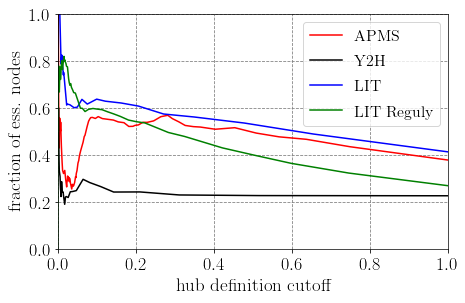

In [19]:
plt.plot(eje_x_APMS,eje_y_APMS,'-r',label='APMS')
plt.plot(eje_x_Y2H,eje_y_Y2H,'-k',label='Y2H')
plt.plot(eje_x_LIT,eje_y_LIT,'-b',label='LIT')
plt.plot(eje_x_LIT_Reguly,eje_y_LIT_Reguly,'-g',label='LIT Reguly')
pylab.xlabel('hub definition cutoff')
pylab.ylabel('fraction of ess. nodes')
plt.grid(color='gray', linestyle='--')
pylab.ylim(0, 1)
pylab.xlim(0, 1)
plt.legend()
pylab.savefig('fig1_zotenko.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
def funcion_remove_random(red,umbral):
    copia_red = red.copy()
    size_giant_original = len(max(nx.connected_components(red),key=len))
    eje_x = []
    eje_y = []
    cantidad_nodos = copia_red.number_of_nodes()
    cantidad_maxima_nodos_removidos = int(umbral*red.number_of_nodes())
    for i in range(0,cantidad_maxima_nodos_removidos):
        ListOfNodes = copia_red.nodes()
        RandomSample = random.sample(ListOfNodes, 1)
        copia_red.remove_nodes_from(RandomSample)
        eje_x+=[i/float(cantidad_nodos)]
        cantidad_nodos_copia = copia_red.number_of_nodes()
        size_giant_copia = len(max(nx.connected_components(copia_red),key=len))
        calculo = size_giant_copia/float(size_giant_original)    
        eje_y+=[calculo]
    return(eje_x,eje_y)

In [21]:
resultado = funcion_remove_random(G_APMS,0.35)

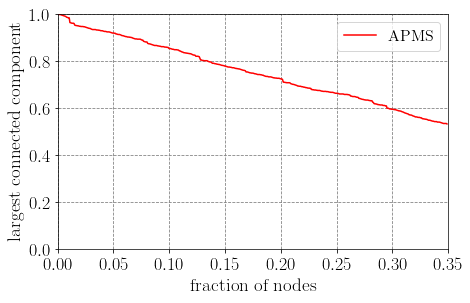

In [22]:
plt.plot(resultado[0],resultado[1],'-r',label='APMS')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
plt.grid(color='gray', linestyle='--')
pylab.ylim(0, 1)
pylab.xlim(0, 0.35)
plt.legend()
plt.show()

In [23]:
### Remueve los nodos que tienen mayor centralidad segun Current Flow Betweeness centrality
### Lo hace solo para la componente gigante (no se considera el resto de los subgrafos)
def funcion_remove_cf3(red,umbral):
    copia_red = red.copy()
    size_giant_original = len(max(nx.connected_components(red),key=len))
    eje_x = []
    eje_y = []
    cantidad_nodos = red.number_of_nodes()
    porcentaje = 0
    paso = 2
    ## Creamos un diccionario con los nodos y su respectivo flujo
    Gc =  max(nx.connected_component_subgraphs(copia_red), key=len)
    dict_component = nx.current_flow_betweenness_centrality(Gc, weight='weight', dtype='float', solver='lu')
    ## Ordenamos el diccionario de menor a mayor
    sorted_x = sorted(dict_component.items(), key=operator.itemgetter(1),reverse=True)
    sorted_array = np.array(list(sorted_x))  
    while (porcentaje<=umbral):
        copia_red = red.copy()
        # Removemos los n nodos de centralidad mas alta
        n = int(porcentaje*cantidad_nodos/100.0)
        for i in range(0,n):
            nombre = sorted_array[i][0]
            copia_red.remove_node(nombre)
        # Calculamos el tamano de la componente gigante (luego de remover nodos)
        size_giant_copia = len(max(nx.connected_components(copia_red),key=len))
        calculo = size_giant_copia/float(size_giant_original)    
        eje_y+=[calculo]
        eje_x+=[porcentaje/100.0]        
        porcentaje+=paso
    return(eje_x,eje_y)

In [ ]:
resultado_current_flow_APMS = funcion_remove_cf3(G_APMS,35)

In [ ]:
plt.plot(resultado_current_flow_APMS[0],resultado_current_flow_APMS[1],'-r',label='APMS')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
plt.grid(color='gray', linestyle='--')
pylab.ylim(0, 1)
pylab.xlim(0, 0.35)
plt.legend()
plt.show()

In [ ]:
### Remueve los nodos que tienen mayor centralidad segun Shortest path (betweenness_centrality)
### Lo hace solo para la componente gigante (no se considera el resto de los subgrafos)
def funcion_remove_sp(red,umbral):
    copia_red = red.copy()
    size_giant_original = len(max(nx.connected_components(red),key=len))
    eje_x = []
    eje_y = []
    cantidad_nodos = red.number_of_nodes()
    porcentaje = 0
    paso = 2
    ## Creamos un diccionario con los nodos y su respectivo shortest path
    Gc =  max(nx.connected_component_subgraphs(copia_red), key=len)
    dict_component = nx.betweenness_centrality(Gc)
    ## Ordenamos el diccionario de menor a mayor
    sorted_x = sorted(dict_component.items(), key=operator.itemgetter(1),reverse=True)
    sorted_array = np.array(list(sorted_x))  
    while (porcentaje<=umbral):
        copia_red = red.copy()
        # Removemos los n nodos de centralidad mas alta
        n = int(porcentaje*cantidad_nodos/100.0)
        for i in range(0,n):
            nombre = sorted_array[i][0]
            copia_red.remove_node(nombre)
        # Calculamos el tamano de la componente gigante (luego de remover nodos)
        size_giant_copia = len(max(nx.connected_components(copia_red),key=len))
        calculo = size_giant_copia/float(size_giant_original)    
        eje_y+=[calculo]
        eje_x+=[porcentaje/100.0]        
        porcentaje+=paso
    return(eje_x,eje_y)

In [ ]:
resultado_shortest_path_APMS = funcion_remove_sp(G_APMS,35)

In [ ]:
plt.plot(resultado[0],resultado[1],'-k',label='random')
plt.plot(resultado_shortest_path_APMS[0],resultado_shortest_path_APMS[1],'-r',label='shortest-path')
plt.plot(resultado_current_flow_APMS[0],resultado_current_flow_APMS[1],'-b',label='current flow')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
plt.grid(color='gray', linestyle='--')
pylab.ylim(0, 1)
pylab.xlim(0, 0.35)
plt.legend()
plt.show()

Pruebas de centralidad con todas las componentes (no unicamente la componente gigante)

In [ ]:
### Remueve los nodos que tienen mayor centralidad segun Current Flow Betweeness centrality
### Lo hace para todas las componentes de la red. 

def funcion_remove_cf2(red,umbral):
    size_giant_original = len(max(nx.connected_components(red),key=len))
    eje_x = []
    eje_y = []
    cantidad_nodos = red.number_of_nodes()
    porcentaje = 0
    paso = 2
    ## Creamos un diccionario con los nodos y su respectiva centralidad de flujo
    dict_all = dict()
    for component in nx.connected_component_subgraphs(red):
        if component.number_of_nodes()>1:
            dict_component = nx.current_flow_betweenness_centrality(component, normalized = False,weight='weight', dtype='float', solver='lu')
           # print(dict_component)
            dict_all.update(dict_component)
    ## Ordenamos el diccionario de menor a mayor
    sorted_x = sorted(dict_all.items(), key=operator.itemgetter(1),reverse=True)
    sorted_array = np.array(list(sorted_x)) 
    #print("Sorted array:",sorted_array)
    while (porcentaje<=umbral):
        copia_red = red.copy()
        # Removemos los n nodos de centralidad mas alta
        n = int(porcentaje*cantidad_nodos/100.0)
        for i in range(0,n):
            nombre = sorted_array[i][0]
            copia_red.remove_node(nombre)
            #sorted_x = [i for i in sorted_x if i[0] != max(sorted_x)[0]]
        # Calculamos el tamano de la componente gigante (luego de remover nodos)
        size_giant_copia = len(max(nx.connected_components(copia_red),key=len))
        calculo = size_giant_copia/float(size_giant_original)    
        eje_y+=[calculo]
        eje_x+=[porcentaje/100.0]        
        porcentaje+=paso
    return(eje_x,eje_y)

In [ ]:
### Remueve los nodos que tienen mayor centralidad segun Shortest path (betweenness_centrality)
### Lo hace para todas las componentes de la red. 

def funcion_remove_sp2(red,umbral):
    copia_red = red.copy()
    size_giant_original = len(max(nx.connected_components(red),key=len))
    eje_x = []
    eje_y = []
    cantidad_nodos = red.number_of_nodes()
    porcentaje = 0
    paso = 2
    ## Creamos un diccionario con los nodos y su respectiva centralidad de flujo
    dict_all = dict()
    for component in nx.connected_component_subgraphs(red):
        if component.number_of_nodes()>1:
            #dict_component = nx.current_flow_betweenness_centrality(component, normalized = False,weight='weight', dtype='float', solver='lu')
            dict_component = nx.betweenness_centrality(component, normalized = False)
            dict_all.update(dict_component)
    ## Ordenamos el diccionario de menor a mayor
    sorted_x = sorted(dict_all.items(), key=operator.itemgetter(1),reverse=True)
    sorted_array = np.array(list(sorted_x))  
    while (porcentaje<=umbral):
        copia_red = red.copy()
        # Removemos los n nodos de centralidad mas alta
        n = int(porcentaje*cantidad_nodos/100.0)
        for i in range(0,n):
            nombre = sorted_array[i][0]
            copia_red.remove_node(nombre)
        # Calculamos el tamano de la componente gigante (luego de remover nodos)
        size_giant_copia = len(max(nx.connected_components(copia_red),key=len))
        calculo = size_giant_copia/float(size_giant_original)    
        eje_y+=[calculo]
        eje_x+=[porcentaje/100.0]        
        porcentaje+=paso
    return(eje_x,eje_y)

In [ ]:
resultado_current_flow2_LIT = funcion_remove_cf2(G_LIT,35)

In [ ]:
resultado_current_flow2_Y2H = funcion_remove_cf2(G_Y2H,35)

In [ ]:
#resultado_current_flow2_LIT_Reguly = funcion_remove_cf2(G_LIT_Reguly,35)

In [ ]:
plt.plot(resultado_current_flow2_LIT[0],resultado_current_flow2_LIT[1],'-b',label='lit')
plt.plot(resultado_current_flow2_APMS[0],resultado_current_flow2_APMS[1],'-r',label='apms')
plt.plot(resultado_current_flow2_Y2H[0],resultado_current_flow2_Y2H[1],'-g',label='y2h')
#plt.plot(resultado_current_flow2_LIT-Reguly[0],resultado_current_flow2_LIT-Reguly[1],'-k',label='lit reguly')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
plt.grid(color='gray', linestyle='--')
pylab.ylim(0, 1.0)
pylab.xlim(0, 0.35)
plt.legend()
plt.show()

In [ ]:
def grado_max(red):
    cantidad_nodos = red.number_of_nodes()
    maximo = 0
    i=0
    while i<cantidad_nodos:
        if list(red.degree)[i][1]>maximo:
            maximo = list(red.degree)[i][1]
        i+=1
    return maximo

In [ ]:
def remove_degree_porcentaje(copia_red,porcentaje_nodos,vector_grados):
    
    numero_nodos = copia_red.number_of_nodes()
    nodos_considerados = int(numero_nodos * porcentaje_nodos / 100.0)
    l = len(vector_grados)
    contador = 0
    i = 0

    #me fijo a que k corresponde ese porcentaje de nodos
    while contador <= nodos_considerados:
        contador += vector_grados[l-i-1]
        i+=1
  
    k_max = l - (i - 1)
    len_red = len(copia_red)
    grado_maximo = k_max
    
    while grado_maximo >= k_max:
        i = 0
        while i < len_red:
            grado = list(copia_red.degree)[i][1]
            nombre = list(copia_red)[i]
            if grado >= k_max:
                copia_red.remove_nodes_from([nombre])
                len_red = len(copia_red)
                #i = 0
                i = i - 1
            else:
                i+=1
        grado_maximo = grado_max(copia_red)

    f = copia_red.number_of_nodes()
    componente_gigante = 0
    if(f>0): 
        componente_gigante = max(nx.connected_components(copia_red), key=len)
    
    grafo_componente_gigante = copia_red.subgraph(componente_gigante)
    g = grafo_componente_gigante.number_of_nodes()

    return g  

In [ ]:
def funcion_remove_degree(red,umbral):

    componente_gigante_red_original = max(nx.connected_components(red), key=len)
    grafo_componente_gigante_red_original = red.subgraph(componente_gigante_red_original)
    nodos_componente_gigante_red_original = grafo_componente_gigante_red_original.number_of_nodes()
    
    paso = 2
    m = umbral / paso
    eje_x = np.zeros(m+1)
    eje_y = np.zeros(m+1)
    vector_grados = distribucion_grado(red)[0]
    porcentaje_nodos = 0
    
    i = 0
    while porcentaje_nodos <= umbral:
        copia_red=red.copy()
        eje_x[i] = porcentaje_nodos/100.0
        eje_y[i] = remove_degree_porcentaje(copia_red,porcentaje_nodos,vector_grados)/(float(nodos_componente_gigante_red_original))
        
        porcentaje_nodos += paso
        i+=1
    
    return(eje_x,eje_y)

In [ ]:
def clasificacion_eigenvector(eigenvector_array):
    
    l = len(eigenvector_array)
    vector_eigenvector = np.zeros(l)
    i = 0
    while i < l:
        vector_eigenvector[i] = eigenvector_array[i][1]
        i += 1
    
    return(vector_eigenvector)


In [ ]:
def remove_eigenvector_porcentaje(copia_red,porcentaje_nodos,eigenvector):
    
    numero_nodos = copia_red.number_of_nodes()
    nodos_considerados = int(numero_nodos * porcentaje_nodos / 100.0)
    l = len(eigenvector)
    contador = 0
    
    eigenvector_array = np.array(list(eigenvector.items()))
    vector_eigenvector = clasificacion_eigenvector(eigenvector_array)
    eigenvector_ordenado = np.sort(vector_eigenvector)
    
    len_eigenvector = len(eigenvector_ordenado)
    indice_max = nodos_considerados

    eigenvector_max = eigenvector_ordenado[l-indice_max-1]
    len_red = len(copia_red)
    eigenvector_maximo = float(eigenvector_max)
    
    i = 0
    while i < len_red:
        autovector_i = float(eigenvector_array[i][1])
        nombre = eigenvector_array[i][0]

        if autovector_i >= eigenvector_maximo:
            copia_red.remove_nodes_from([nombre])
            len_red = len(copia_red)
        i+=1

    f = copia_red.number_of_nodes()
    componente_gigante = 0
    if(f>0): 
        componente_gigante = max(nx.connected_components(copia_red), key=len)
    
    grafo_componente_gigante = copia_red.subgraph(componente_gigante)
    g = grafo_componente_gigante.number_of_nodes()

    return g 

In [ ]:
def funcion_remove_eigenvector(red,umbral):

    componente_gigante_red_original = max(nx.connected_components(red), key=len)
    grafo_componente_gigante_red_original = red.subgraph(componente_gigante_red_original)
    nodos_componente_gigante_red_original = grafo_componente_gigante_red_original.number_of_nodes()
    
    paso = 1
    m = umbral / paso
    eje_x = np.zeros(m+1)
    eje_y = np.zeros(m+1)
    
    eigenvector = nx.eigenvector_centrality(red,max_iter=100)
    
    porcentaje_nodos = 0
    
    i = 0
    while porcentaje_nodos <= umbral:
        copia_red=red.copy()
        eje_x[i] = porcentaje_nodos/100.0
        eje_y[i] = remove_eigenvector_porcentaje(copia_red,porcentaje_nodos,eigenvector)/(float(nodos_componente_gigante_red_original))
        
        porcentaje_nodos += paso
        i+=1
    
    return(eje_x,eje_y)

In [ ]:
def rem_esenciales(red):

    copia_red=red.copy()
    nodos_red_original = copia_red.number_of_nodes()

    comp_gigante_original = max(nx.connected_component_subgraphs(copia_red), key=len)
    nodos_comp_gigante_original = comp_gigante_original.number_of_nodes()
    
    l = len(yeast_G_ESSENTIAL_raw[0][:])
    copia_red.remove_nodes_from(yeast_G_ESSENTIAL_raw[0][:])
    nodos_red_removida = copia_red.number_of_nodes()

    nodos_removidos = nodos_red_original - nodos_red_removida
    comp_gigante_removida = max(nx.connected_component_subgraphs(copia_red), key=len)
    nodos_comp_gigante_removida = comp_gigante_removida.number_of_nodes()
    
    eje_x = nodos_removidos / (float(nodos_red_original))
    eje_y = nodos_comp_gigante_removida / (float(nodos_comp_gigante_original))

    return(eje_x,eje_y)


### Data para graficar APMS

In [ ]:
# Shortest path
resultado_shortest_path2_APMS = funcion_remove_sp2(G_APMS,50)

In [ ]:
# Current flow
resultado_current_flow2_APMS = funcion_remove_cf2(G_APMS,50)

In [ ]:
# Random
resultado_random_APMS =  funcion_remove_random(G_APMS,0.50)

In [ ]:
# Degree
resultado_degree_APMS =  funcion_remove_degree(G_APMS,50)

In [ ]:
# Eingenvector
resultado_eingenvector_APMS =  funcion_remove_eigenvector(G_APMS,50)

In [ ]:
# Esenciales
resultado_esenciles_APMS =  rem_esenciales(G_APMS)

In [ ]:
### Grafico APMS
plt.plot(resultado_esenciles_APMS[0],resultado_esenciles_APMS[1],'h',markersize='7',color = 'brown',label='essent.')
plt.plot(resultado_degree_APMS[0],resultado_degree_APMS[1],'-r',label='degree')
plt.plot(resultado_eingenvector_APMS[0],resultado_eingenvector_APMS[1],'-',color = 'orange',label='eingenvector')
plt.plot(resultado_shortest_path2_APMS[0],resultado_shortest_path2_APMS[1],'-',color = 'violet',label='shortest-path')
plt.plot(resultado_current_flow2_APMS[0],resultado_current_flow2_APMS[1],'-c',label='current flow')
plt.plot(resultado_random_APMS[0],resultado_random_APMS[1],'-k',label='random')

pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
plt.title('AP-MS network')
#pylab.ylim(0, 1.0)
#pylab.xlim(0, 0.35)
plt.legend(loc='upper right',prop={'size': 11})
pylab.savefig('Fig3_zotenko_APMS.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()




In [ ]:
### Guardamos los archivos

output = np.zeros((len(resultado_degree_APMS[0]),2))
output[:,0] = resultado_degree_APMS[0]
output[:,1] = resultado_degree_APMS[1]
np.savetxt('data_fig3_zotenko_APMS_degree.txt',output,fmt = '%2.3f',delimiter = ' ')

output = np.zeros((len(resultado_eingenvector_APMS[0]),2))
output[:,0] = resultado_eingenvector_APMS[0]
output[:,1] = resultado_eingenvector_APMS[1]
np.savetxt('data_fig3_zotenko_APMS_eingenvector.txt',output,fmt = '%2.3f',delimiter = ' ')

output = np.zeros((len(resultado_shortest_path2_APMS[0]),2))
output[:,0] = resultado_shortest_path2_APMS[0]
output[:,1] = resultado_shortest_path2_APMS[1]
np.savetxt('data_fig3_zotenko_APMS_shortest_path2.txt',output,fmt = '%2.3f',delimiter = ' ')

output = np.zeros((len(resultado_current_flow2_APMS[0]),2))
output[:,0] = resultado_current_flow2_APMS[0]
output[:,1] = resultado_current_flow2_APMS[1]
np.savetxt('data_fig3_zotenko_APMS_current_flow2.txt',output,fmt = '%2.3f',delimiter = ' ')

output = np.zeros((len(resultado_random_APMS[0]),2))
output[:,0] = resultado_random_APMS[0]
output[:,1] = resultado_random_APMS[1]
np.savetxt('data_fig3_zotenko_APMS_random.txt',output,fmt = '%2.3f',delimiter = ' ')

## Data para graficar Y2H

In [ ]:
# Shortest path
resultado_shortest_path2_Y2H = funcion_remove_sp2(G_Y2H,50)

In [ ]:
# Current flow
resultado_current_flow2_Y2H = funcion_remove_cf2(G_Y2H,50)

In [ ]:
# Random
resultado_random_Y2H =  funcion_remove_random(G_Y2H,0.50)

In [ ]:
# Degree
resultado_degree_Y2H =  funcion_remove_degree(G_Y2H,50)

In [ ]:
# Eingenvector
resultado_eingenvector_Y2H =  funcion_remove_eigenvector(G_Y2H,50)

In [ ]:
# Esenciales
resultado_esenciles_Y2H =  rem_esenciales(G_Y2H)

In [ ]:
### Grafico Y2H
plt.plot(resultado_esenciles_Y2H[0],resultado_esenciles_Y2H[1],'h',markersize='7',color = 'brown',label='essent.')
plt.plot(resultado_degree_Y2H[0],resultado_degree_Y2H[1],'-r',label='degree')
plt.plot(resultado_eingenvector_Y2H[0],resultado_eingenvector_Y2H[1],'-',color = 'orange',label='eingenvector')
plt.plot(resultado_shortest_path2_Y2H[0],resultado_shortest_path2_Y2H[1],'-',color = 'violet',label='shortest-path')
plt.plot(resultado_current_flow2_Y2H[0],resultado_current_flow2_Y2H[1],'-c',label='current flow')
plt.plot(resultado_random_Y2H[0],resultado_random_Y2H[1],'-k',label='random')

plt.title('Y2H network')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
#plt.grid(color='gray', linestyle='--')
#pylab.ylim(0, 1.0)
#pylab.xlim(0, 0.35)
plt.legend(loc='upper right',prop={'size': 11})
pylab.savefig('Fig3_zotenko_Y2H.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


## Data para graficar LIT

In [ ]:
# Shortest path
resultado_shortest_path2_LIT = funcion_remove_sp2(G_LIT,50)

In [ ]:
# Current flow
resultado_current_flow2_LIT = funcion_remove_cf2(G_LIT,50)

In [ ]:
# Random
resultado_random_LIT =  funcion_remove_random(G_LIT,0.50)

In [ ]:
# Degree
resultado_degree_LIT =  funcion_remove_degree(G_LIT,50)

In [ ]:
# Eingenvector
resultado_eingenvector_LIT =  funcion_remove_eigenvector(G_LIT,50)

In [ ]:
# Esenciales
resultado_esenciles_LIT =  rem_esenciales(G_LIT)

In [ ]:
### Grafico LIT
plt.plot(resultado_esenciles_LIT[0],resultado_esenciles_LIT[1],'h',markersize='7',color = 'brown',label='essent.')
plt.plot(resultado_degree_LIT[0],resultado_degree_LIT[1],'-r',label='degree')
plt.plot(resultado_eingenvector_LIT[0],resultado_eingenvector_LIT[1],'-',color = 'orange',label='eingenvector')
plt.plot(resultado_shortest_path2_LIT[0],resultado_shortest_path2_LIT[1],'-',color = 'violet',label='shortest-path')
plt.plot(resultado_current_flow2_LIT[0],resultado_current_flow2_LIT[1],'-c',label='current flow')
plt.plot(resultado_random_LIT[0],resultado_random_LIT[1],'-k',label='random')

plt.title('LIT network')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
#plt.grid(color='gray', linestyle='--')
#pylab.ylim(0, 1.0)
#pylab.xlim(0, 0.35)
plt.legend(loc='upper right',prop={'size': 11})
pylab.savefig('Fig3_zotenko_LIT.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


## Data para graficar LIT-Reguly

In [ ]:
# Shortest path
resultado_shortest_path2_LIT_Reguly = funcion_remove_sp2(G_LIT_Reguly,50)

In [ ]:
# Current flow
resultado_current_flow2_LIT_Reguly = funcion_remove_cf2(G_LIT_Reguly,50)

In [ ]:
# Random
resultado_random_LIT_Reguly =  funcion_remove_random(G_LIT_Reguly,0.50)

In [ ]:
# Degree
resultado_degree_LIT_Reguly =  funcion_remove_degree(G_LIT_Reguly,50)

In [ ]:
# Eingenvector
resultado_eingenvector_LIT_Reguly =  funcion_remove_eigenvector(G_LIT_Reguly,50)

In [ ]:
# Esenciales
resultado_esenciles_LIT_Reguly =  rem_esenciales(G_LIT_Reguly)

In [ ]:
### Grafico LIT_Reguly
plt.plot(resultado_esenciles_LIT_Reguly[0],resultado_esenciles_LIT_Reguly[1],'h',markersize='7',color = 'brown',label='essent.')
plt.plot(resultado_degree_LIT_Reguly[0],resultado_degree_LIT_Reguly[1],'-r',label='degree')
plt.plot(resultado_eingenvector_LIT_Reguly[0],resultado_eingenvector_LIT_Reguly[1],'-',color = 'orange',label='eingenvector')
plt.plot(resultado_shortest_path2_LIT_Reguly[0],resultado_shortest_path2_LIT_Reguly[1],'-',color = 'violet',label='shortest-path')
plt.plot(resultado_current_flow2_LIT_Reguly[0],resultado_current_flow2_LIT_Reguly[1],'-c',label='current flow')
plt.plot(resultado_random_LIT_Reguly[0],resultado_random_LIT_Reguly[1],'-k',label='random')
plt.title('LIT Reguly network')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
#plt.grid(color='gray', linestyle='--')
#pylab.ylim(0, 1.0)
#pylab.xlim(0, 0.35)
plt.legend(loc='upper right',prop={'size': 11})
pylab.savefig('Fig3_zotenko_LIT_Reguly.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
### Guardamos los archivos

output = np.zeros((len(resultado_esenciles_LIT_Reguly[0]),2))
output[:,0] = resultado_esenciles_LIT_Reguly[0]
output[:,1] = resultado_esenciles_LIT_Reguly[1]
np.savetxt('data_fig3_zotenko_litreguly_esenciles.txt',output,fmt = '%2.3f',delimiter = ' ')


In [ ]:
print(resultado_esenciles_LIT_Reguly[0])

In [ ]:
def tabla3(red,vecinos):
    A = nx.adjacency_matrix(red)
    A2 = A * A
    A = A.toarray()
    A2 = A2.toarray()
    contador_tipo_indiferente = 0
    contador_mismo_tipo = 0
    l = nx.number_of_nodes(red)
    i = 0
    while i < l:
        j = i + 1
        while j < l:
            enlace_ij = A[i][j]
            if enlace_ij == 0:    #no son adyacentes
                caminos_ij = A2[i][j]   #cantidad de vecinos en comun
                if caminos_ij >= vecinos:
                    contador_tipo_indiferente += 1
                    nombre_i = list(red)[i]
                    nombre_j = list(red)[j]
                    esencialidad_nodo_i = red.node[nombre_i]['esencialidad']
                    esencialidad_nodo_j = red.node[nombre_j]['esencialidad']   
                    if esencialidad_nodo_i==esencialidad_nodo_j:
                        contador_mismo_tipo +=1
            j += 1
        i += 1
    return (contador_tipo_indiferente,contador_mismo_tipo)